# Implementation of a Dynamic Pricing Strategy with a dataset of a ride-sharing company

A ride-sharing company wants to implement a pricing strategy which dynamically adjusts to the current market situation in regard to supply and demand. With that strategy the company wants to optimize their revenue.  
To calcuate the average revenue, the company only uses the ride duration.  

The complete consists of historical ride data and it includes features such as the current number of riders, the current number of drivers, location category, customer loyalty status, number of past rides, average ratings, the time of booking, vehicle type, the expected ride duration and historical cost of the rides.  
It can be found here: https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset  

1. This project aims to develop a predictive model which tries to estimate the optimal price based on real-time market situations as precisely as possible
2. Futhermore it implements a dynamic pricing strategy which should maximize both revenue and customer satisfaction

At the beginning we have to import several libraries to be able to execute the necessary steps:

In [1]:
import os

# Data Manipulation
import numpy as np 
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns


# Preparation of the data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from scipy import stats
from scipy.stats import boxcox_normmax

# Pipeline
from sklearn.pipeline import Pipeline



# Machine Learning Models/Regression Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Metrics for evaluation
import math
from sklearn import metrics 
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

# Show all columns without any restrictions
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Structure: 

1. Loading the data: To start the whole project we have to load the dataset from a file or source, in this case it's a csv-file, into the environment
2. Data Preprocessing: In this step we have to "clean" the data, e.g. handling any missing or inconsistent data, removing duplicates, dealing with outliers and converting data types
3. Exploratory Data Analysis (EDA): Explore the dataset to gain insights and identify patterns. Visualize key features to make it more feasible
4. Feature Engineering: Create new features from raw data to improve the predictive accuracy of the model
5. Model implementation: Critical steps such as data splitting, model training and model evaluation

# 1. Loading the data

In [2]:
# Path to the csv-file
file_path = r"C:\Users\Felix\Desktop\Datensets\dynamic_pricing.csv"

# Loading the csv-file as a DataFrame into a variable df
df = pd.read_csv(file_path)

# Display the first 5 rows of the DataFrame
df.head(n=5)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


# 2. Data Preprocessing

In [3]:
# Create two empty lists to store the following values
objects = []
integers = []

# Loop through the DataFrame
for col in df.columns:
    # Check if the type of the current iterated column is object
    if df[col].dtype == "object":
        # If it is an object, append the name of the column, the number of unique values inside the column
        # and the sum of null-values inside the column to the "objects" list
        objects.append((col, df[col].nunique(), df[col].isnull().sum()))
    # Check if the type of the current iterated column is integer
    else: 
        # If it is not an object, append column name, the number of unique values and the
        # sum of null-values to the "integers" list
        integers.append((col, df[col].nunique(), df[col].isna().sum(), df[col].skew()))

# Determine max length of both lists objects and integers
max_len = max(len(objects), len(integers))

# Now match the maximum length of one list to the other 
# The following line calculates the missing number of elements so "objects" has the same length as the longer list
objects.extend([("","","")] * ((max_len)-len(objects)))
# The following line calculates the missing number of elements so "integers" has the same length as the longer list
integers.extend([("","","","")] * ((max_len)-len(integers)))

# Create DataFrames from the lists
df_objects = pd.DataFrame(objects, columns=["Categorical_columns", "Categorical_unique_values", "Categorical_missing_values"])
df_integers = pd.DataFrame(integers, columns=["Numeric_columns", "Numeric_unique_values", "Numeric_missing_values", "Numeric_Skewness"])

# Combine the DataFrames
df_combined = pd.concat([df_objects, df_integers], axis=1)

# Display the combined DataFrame
df_combined

,Categorical_columns,Categorical_unique_values,Categorical_missing_values,Numeric_columns,Numeric_unique_values,Numeric_missing_values,Numeric_Skewness
0,Location_Category,3,0,Number_of_Riders,81,0,0.002167
1,Customer_Loyalty_Status,3,0,Number_of_Drivers,79,0,0.963204
2,Time_of_Booking,4,0,Number_of_Past_Rides,101,0,-0.008457
3,Vehicle_Type,2,0,Average_Ratings,151,0,-0.078754
4,,,,Expected_Ride_Duration,171,0,-0.139868
5,,,,Historical_Cost_of_Ride,1000,0,0.209580


In [4]:
df.shape

(1000, 10)

Now the analysis of the dataset is a lot easier:  

1. The dataset consists of 1000 entries and has no missing values in any column  
2. It consists of a total of 10 different features, where 4 are categorical and 6 are numeric  
3. The number of unique values for each feature is shown in the DataFrame above. There are 81 unique values for the number of riders and 2 unique values for the vehicle type
4. Futhermore the skewness of all numeric columns was calculated, which will be required in the later steps of the analysis  

Alternatively we could use ```df.info()``` to gain information about the total number of rows and the datatype of each columns.  
```df[column_name].value_counts()``` counts the number of different values in each column.  
```df.duplicated().sum()``` checks if thehre are any duplicated rows in the DataFrame which should be removed.

In [5]:
# Fundamental information about the dataset (e.g. precise datatypes, number and name of columns, number of rows, number of non-null values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [6]:
# e.g. number of values of each characteristic in the objective columns "Customer_Loyalty_Status", "Location_Category", "Time_of_Booking", "Vehicle_Type":
print(df["Customer_Loyalty_Status"].value_counts())
print()
print(df["Location_Category"].value_counts())
print()
print(df["Time_of_Booking"].value_counts())
print()
df["Vehicle_Type"].value_counts()

Customer_Loyalty_Status
Silver     367
Regular    320
Gold       313
Name: count, dtype: int64

Location_Category
Urban       346
Rural       332
Suburban    322
Name: count, dtype: int64

Time_of_Booking
Night        276
Afternoon    247
Morning      246
Evening      231
Name: count, dtype: int64



Vehicle_Type
Premium    522
Economy    478
Name: count, dtype: int64

In [7]:
# Counting the number of duplicated rows in the DataFrame in total
df.duplicated().sum()

0

Since there don't exist any missing values or duplicated rows, we don't have to handle those.  
In case of duplicated rows, we should simply remove them from our dataset.  

In case of missing values in numerical features there exist 3 different approaches:
1. Delete the rows if it's just a small number and doesn't affect the dataset (with df.drop(axis = 0))
2. Delete the column, but only if it has a high number of missing values and if it doesnt affect the dataset (with df.drop(axis = 1))
3. Fill in the median or mean of the column (with df.fillna())  

Step 1 and 2 also apply for categorical columns, but step 3 is slightly different, since you can only fill in the mode of the column, which means you search for the value with the most occurences and use that as the filler.

# 3. Exploratory Data Analysis

In [8]:
# Show the basic, descriptive statistics for all numerical columns in the DataFrame
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [9]:
# Show the basic, descriptive statistics for all objective columns in the DataFrame
df.describe(include="object")

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,1000,1000,1000,1000
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,346,367,276,522


## 3.1 Visualize both numerical and categorical columns from the DataFrame 

In [10]:
numerical_columns = df.select_dtypes(include="number")
numerical_columns

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,13,4.47,90,284.257273
1,58,39,72,4.06,43,173.874753
2,42,31,0,3.99,76,329.795469
3,89,28,67,4.31,134,470.201232
4,78,22,74,3.77,149,579.681422
...,...,...,...,...,...,...
995,33,23,24,4.21,11,91.389526
996,84,29,92,4.55,94,424.155987
997,44,6,80,4.13,40,157.364830
998,53,27,78,3.63,58,279.095048


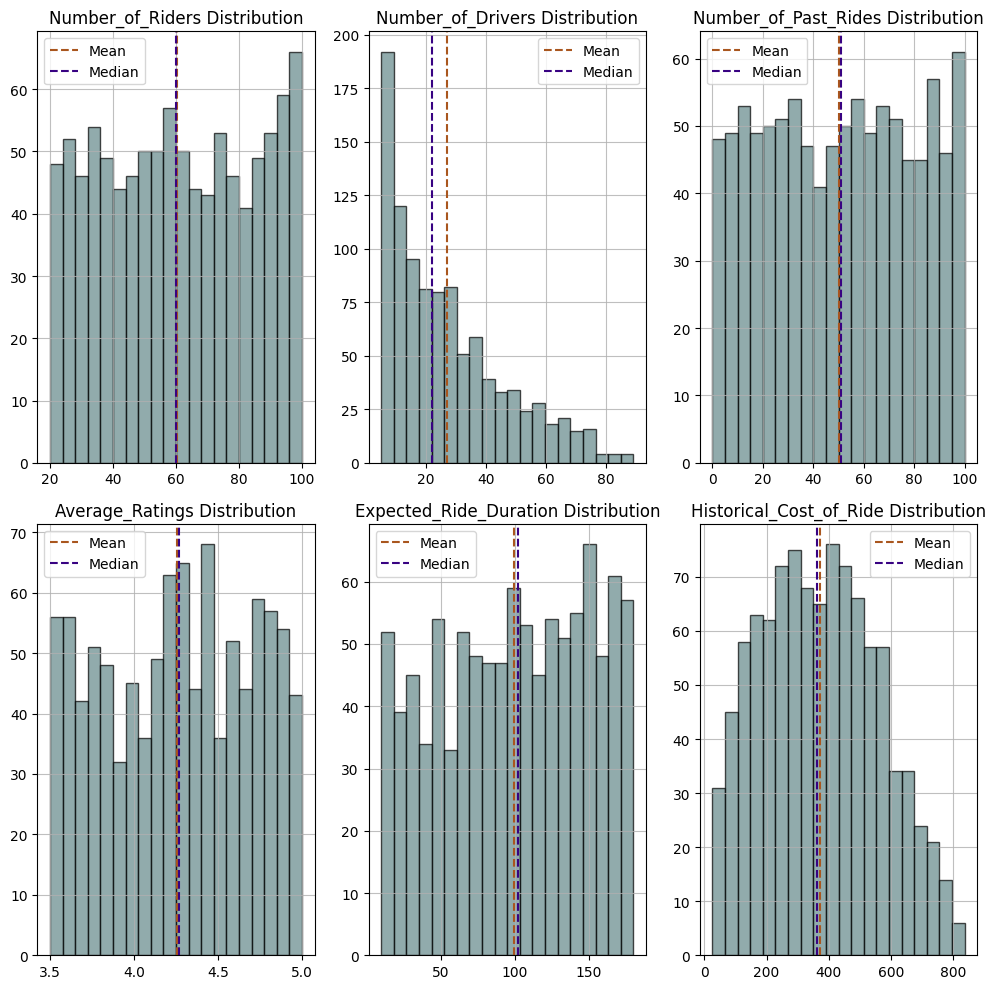

In [11]:
# Choose numerical columns from the DataFrame (n = 6)
numerical_columns = df.select_dtypes(include="number")

# Calculate the number of plots, columns and rows
num_plots = len(numerical_columns.columns) 
# num_plots = 6 since there exists 6 different columns
num_columns = 3
# num_columns = 3 because we want 3 columns for each row to maintain a practical overview
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0) 
# num_rows = 2, if there exists e.g 7 or 8 columns, we have to add an additional row, with 9 columns, it automatically implements 3 rows

# Create a figure with the size of the number of rows
plt.figure(figsize = (10, 5 * num_rows))

# Iterate over each numerical column and create a subplot (in this case a histogram to visualize the distribution of values in each column)
for i, col in enumerate(numerical_columns, start = 1):
    # Create Subplot
    plt.subplot(num_rows, num_columns, i)
    mean_values = numerical_columns[col].mean()
    median = numerical_columns[col].median()

    # Plot histogram
    plt.hist(numerical_columns[col], bins=20, edgecolor = "black", color = "#638889", alpha = 0.7)
    # Plot mean-line
    plt.axvline(x = mean_values, linestyle = "--", color = "#A9561E", label = "Mean")
    # Plot median-line
    plt.axvline(x = median, linestyle = "--", color = "#380282", label = "Median")
    # Create gridlines within each plot 
    plt.grid(True, alpha = 0.8)
    # Plot title of each graph
    plt.title(f"{col} Distribution")
    # Show legend
    plt.legend()

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

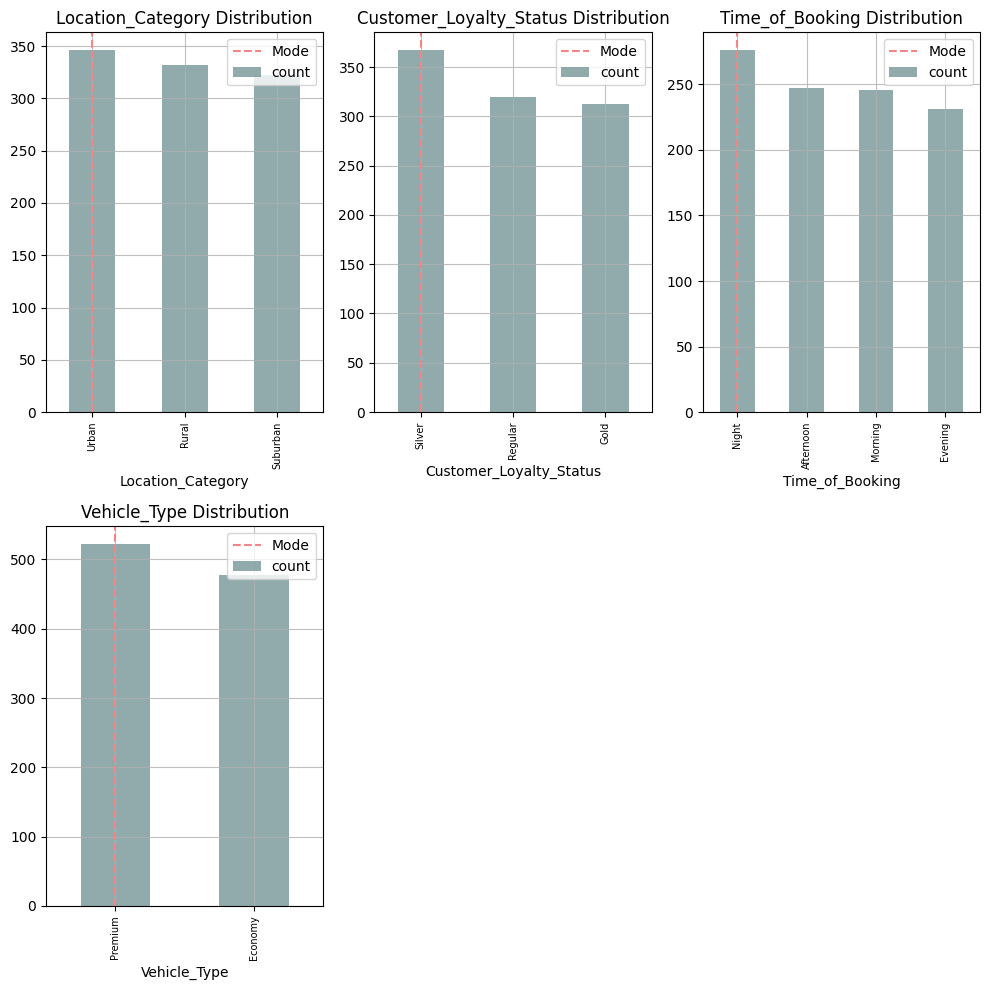

In [12]:
# Choose categorical columns from the DataFrame (n = 4)
categorical_columns = df.select_dtypes(include="object").columns

# Calculate the number of plots, columns and rows
num_plots = len(categorical_columns)
# num_plots = 6 since there exists 6 different columns
num_columns = 3
# num_columns = 3 because we want 3 columns for each row to maintain a practical overview
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0) 
# num_rows = 2, if there exists e.g 7 or 8 columns, we have to add an additional row, with 9 columns, it automatically implements 3 rows

# Create a figure with the size of the number of rows
plt.figure(figsize = (10, 5 * num_rows))

# Iterate over each numerical column and create a subplot (in this case a histogram to visualize the distribution of values in each column)
for i, col in enumerate(df[categorical_columns], start = 1):
    mode = df[col].mode()[0]  
    # Create Subplot
    plt.subplot(num_rows, num_columns, i)
    
    # Create Barplot
    df[col].value_counts().plot(kind="bar", color="#638889", alpha=0.7)  
    # Create mode-line
    plt.axvline(x=df[col].value_counts().index.get_loc(mode), color="#F28585", linestyle="--", label="Mode")
    # Create gridlines within each plot 
    plt.grid(True, alpha = 0.8)
    plt.xticks(fontsize=7)  
    # Plot title of each graph
    plt.title(f"{col} Distribution")
    # Show legend
    plt.legend()

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

## 3.2 Detect outliers and inconsistent data

- A popular and easy method for detecting outliers is the Z-score method. (```z = (X – μ) / σ```)  
- Z-score is a statistical measure that quantifies the distance between a data point and the mean of a dataset.
- It's expressed in terms of standard deviations. It indicates how many standard deviations a data point is from the mean of the distribution.
- If the Z-score is below a lower or above an upper threshold, it is considered as an outlier and will not be used for further calculations.
- For simplicity, that threshold is set as a fixed value of +3 and -3.

<function matplotlib.pyplot.show(close=None, block=None)>

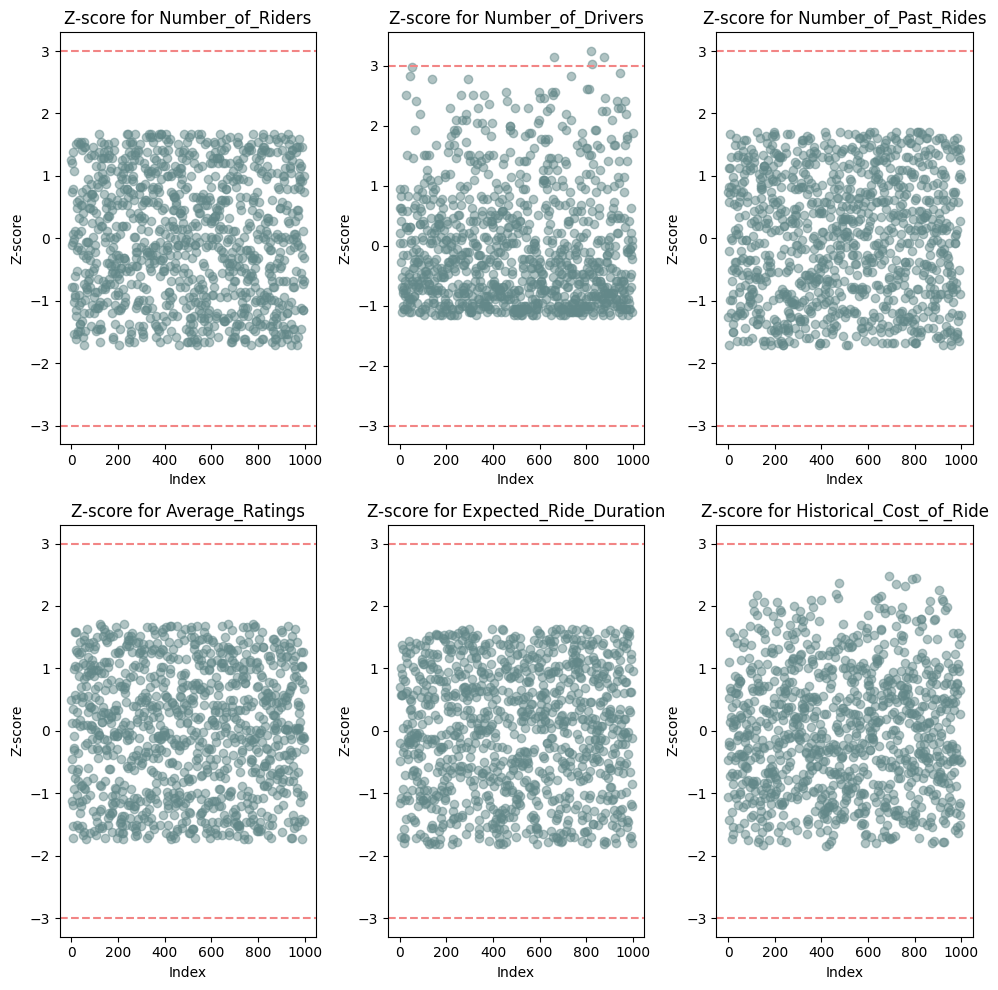

In [13]:
# Only numerical columns can be used for the calculation of a Z-score
# Same procedure as for visualizing the distribution of the values for each column
# Choose numerical columns from the DataFrame (n = 6)
numerical_columns = df.select_dtypes(include=np.number)

# Calculate the number of plots, columns and rows
num_plots = len(numerical_columns.columns) 
# num_plots = 6 since there exists 6 different columns
num_columns = 3
# num_columns = 3 because we want 3 columns for each row to maintain a practical overview
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0) 
# num_rows = 2, if there exists e.g 7 or 8 columns, we have to add an additional row, with 9 columns, it automatically implements 3 rows

# Create a figure with the size of the number of rows
plt.figure(figsize = (10, 5 * num_rows))

for i, col in enumerate(numerical_columns, 1):
    # Create subplot
    plt.subplot(num_rows, num_columns, i)
    # Calculation the z-scores
    z_scores = (numerical_columns[col] - numerical_columns[col].mean()) / numerical_columns[col].std()
    # Defining the threshold
    threshold = 3
    
    # Create a scatterplot for each column
    plt.scatter(np.arange(len(z_scores)), z_scores, color="#638889", alpha = 0.5)
    plt.axhline(y=threshold, linestyle="--", color="#F28585", label = "Treshold")
    plt.axhline(y=-threshold, linestyle="--", color="#F28585")
    plt.xlabel("Index")
    plt.ylabel("Z-score")
    plt.title(f"Z-score for {col}")

plt.tight_layout()
plt.show

Here we can see that the only existing outliers are in the column ```["Number_of_Drivers"]```, which means for further calculations we improve the predicting power of our model by deleting them, since they might negatively influence the machine learning model later on. Since they are only a few (counting with the eye: n = 4), they also can be ignored.

## 3.3 Visualizing correlation

<Axes: >

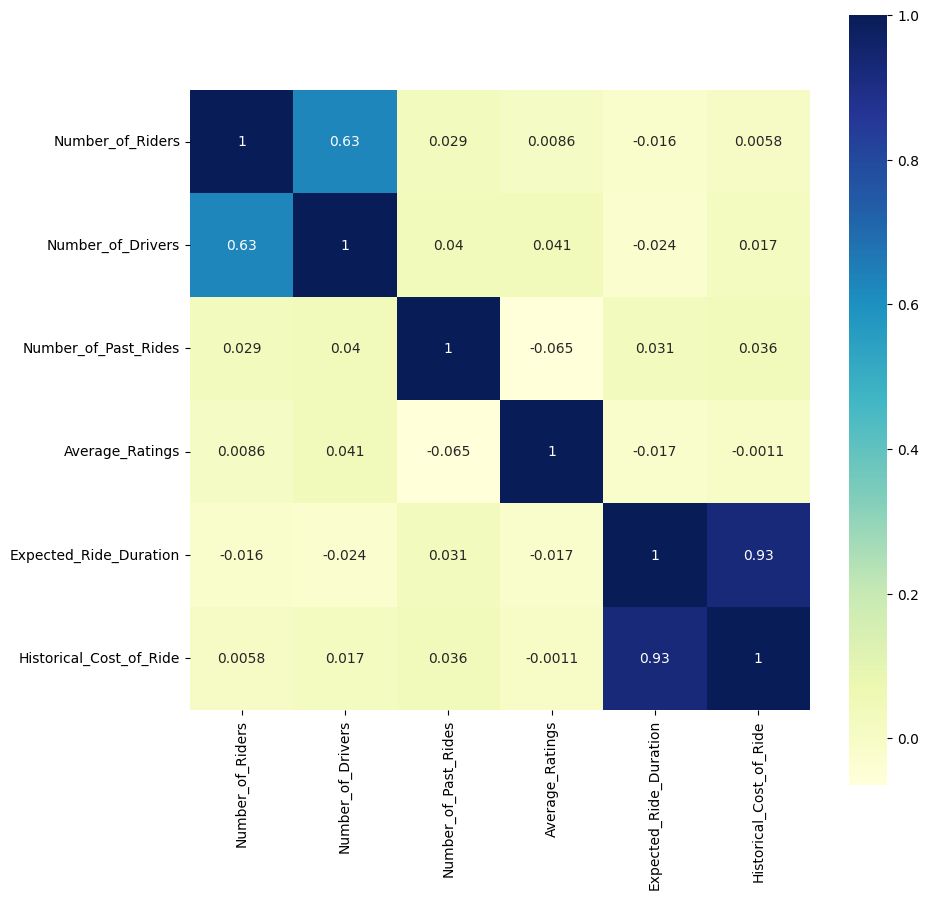

In [14]:
corr_map = df.corr(numeric_only = True)
corr_map

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
sns.heatmap(data = corr_map, cmap="YlGnBu", annot = True, square = True)

- Here we can see that their exists a strong, positive correlation (0.93) between the Expected_Ride_Duration and the Historical_Cost_of_Ride
- That means that the Expected_Ride_Duration has by far the biggest influence on the Historical_Cost_of_Ride
- With this information we can plot both features against each other to gain further insights.

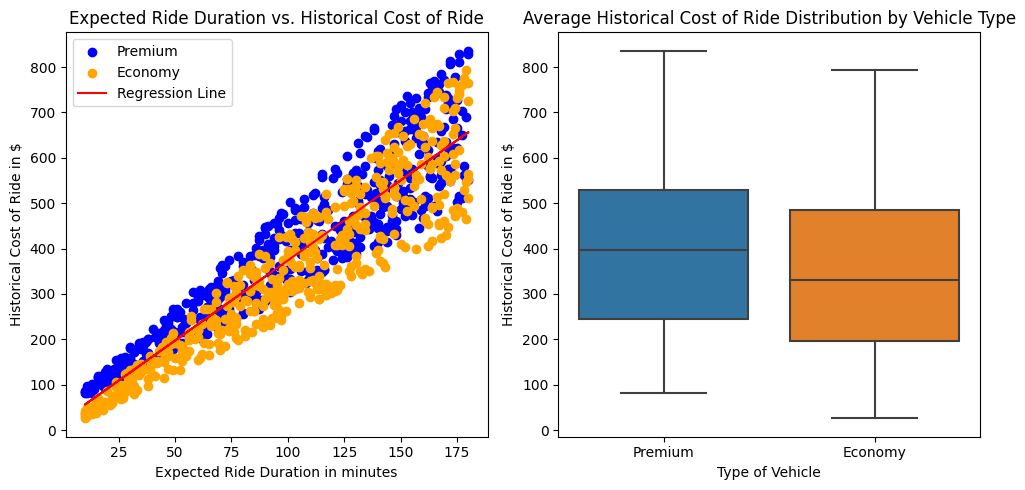

In [15]:
# Scatterplot of Historical_Cost_of_Ride and Expected_Ride_Duration

# Match features to variables and colors to characteristics of the feature "Vehicle"

x_points = df["Expected_Ride_Duration"]
y_points = df["Historical_Cost_of_Ride"]
colors = {"Economy": "orange", "Premium": "blue"}
df["Color"] = df["Vehicle_Type"].map(colors)

# Reshaping the data
X = df['Expected_Ride_Duration'].values.reshape(-1, 1)
Y = df['Historical_Cost_of_Ride'].values

# Calculating regression line 
model = LinearRegression()
model.fit(X, Y)
reg_line = model.predict(X)

fig = plt.figure(figsize = (10,5))

# Plotting both scatter plot (blue) and regression line (red)
ax = fig.add_subplot(1,2,1)

for vehicle_type in df["Vehicle_Type"].unique():
    indices = df["Vehicle_Type"] == vehicle_type
    ax.scatter(x = x_points[indices], y = y_points[indices], color = colors[vehicle_type], label = vehicle_type)
    
ax.plot(x_points, reg_line, color = "red", label = "Regression Line")

# Title and name of axes
ax.set_title("Expected Ride Duration vs. Historical Cost of Ride")
ax.set_xlabel("Expected Ride Duration in minutes")
ax.set_ylabel("Historical Cost of Ride in $")
ax.legend()

# Plotting the average costs of these rides based on the type of car the customer chose (premium vs. economy)
ax2 = fig.add_subplot(1,2,2)
sns.boxplot(x='Vehicle_Type', y='Historical_Cost_of_Ride', data=df)

# Title and name of axes
ax2.set_title("Average Historical Cost of Ride Distribution by Vehicle Type")
ax2.set_xlabel("Type of Vehicle")
ax2.set_ylabel("Historical Cost of Ride in $")

plt.tight_layout()
plt.show()

# 4. Feature Engineering

Now, to advance in the goal to establish a dynamic pricing strategy we have to implement a new feature which is called ```Adjusted_Ride_Cost```.  
The implementation of it requires several steps:

1. Creating a ```Demand_Multiplier```: It's calculated based on the percentile for high and low demand. The ```Number_of_Riders``` will be compared to the respective percentiles. If the number of passengers is higher than the ```high_demand_percentile```, the multiplier is calculated as the proportion of the number of drivers to the high_demand_percentile. If the number is lower, it's calculated with the ```low_demand_percentile```
2. Creating a ```Supply_Multiplier```: Same as the demand_multiplier but vice versa: If the ```Number_of_Drivers``` is above the ```low_supply_percentile```, the multiplier is calculated as the proportion of the ```high_supply_percentile```to the number of drivers and vice versa
3. Defining ```Price_Adjustment_Factors```: The four factors will be defined to set thresholds for low/high demand/supply
4. ```Adjusted_Ride_Calculation```: The calculation of the ```Adjusted_Ride_Cost``` is based on the multiplication of the ```Historical_Cost_of_Ride``` with the ```Price_Adjustment_Factors```

These steps allow us to dynamically adjust the Historic_Ride_Cost according to the current market situation and therefore optimize pricing and maximize revenue.

In [16]:
# To implement such a dynamic pricing strategy, we have to calculate a demand-mulitplier based on the percentiles for high and low demand
high_demand_percentile = 75 
low_demand_percentile = 25

df["Demand_Multiplier"] = np.where(df["Number_of_Riders"] > np.percentile(df["Number_of_Riders"], high_demand_percentile),
                                   df["Number_of_Riders"] / np.percentile(df["Number_of_Riders"], high_demand_percentile),
                                   df["Number_of_Riders"] / np.percentile(df["Number_of_Riders"], low_demand_percentile))

# The same procedure has to be executed for the supply-multiplier

high_supply_percentile = 75
low_supply_percentile = 25

df["Supply_Multiplier"] = np.where(df["Number_of_Drivers"] > np.percentile(df["Number_of_Drivers"], low_supply_percentile),
                                   np.percentile(df["Number_of_Drivers"], high_supply_percentile) / df["Number_of_Drivers"],
                                   np.percentile(df["Number_of_Drivers"], low_supply_percentile) / df["Number_of_Drivers"])

# In the next step we have to calculate the price adjustment for high/low demand/supply

high_demand_multiplier = 1.2
low_demand_multiplier = 0.8
high_supply_multiplier = 0.8
low_supply_multiplier = 1.2

# Now calculate the adjusted ride cost for dynamic pricing

df["Adjusted_Ride_Cost"] = df["Historical_Cost_of_Ride"] * (
    np.maximum(df["Demand_Multiplier"], low_demand_multiplier) *
    np.maximum(df["Supply_Multiplier"], high_supply_multiplier)
)

df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Color,Demand_Multiplier,Supply_Multiplier,Adjusted_Ride_Cost
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,blue,1.111111,0.844444,266.710528
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,orange,1.450000,0.974359,245.653817
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,blue,1.050000,1.225806,424.478684
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,blue,1.098765,1.357143,701.155452
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,orange,1.950000,1.727273,1952.472427


As the next step we have to calculate wether the adjusted price is profitable or not.  
The profitability is calculated by dividing the result of the substraction of the ```Adjusted_Ride_Cost``` with ```Historical_Cost_of_Ride``` by the ```Historical_Cost_of_Ride```. To gain the profit percentage, we have to multiply that by 100.  
Afterwards, the ```Profit_Percentage``` is visualized.

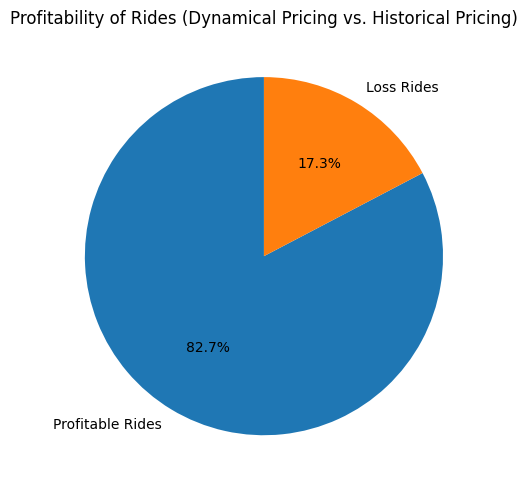

In [17]:
# Calculate the profit percentage
df["Profit_Percentage"] = ((df["Adjusted_Ride_Cost"] - df["Historical_Cost_of_Ride"]) / df["Historical_Cost_of_Ride"]) * 100

# Identify both positive and negative profits
profitable_rides = df[df["Profit_Percentage"] > 0]
loss_rides = df[df["Profit_Percentage"] < 0] 

# Count of both variables
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a pie chart
labels = ["Profitable Rides",
          "Loss Rides"]
values = [profitable_count,
          loss_count]

plt.figure(figsize=(5, 5))

plt.pie(values, labels = labels, autopct='%1.1f%%', startangle = 90)
plt.title("Profitability of Rides (Dynamical Pricing vs. Historical Pricing)")

plt.tight_layout()
plt.show()

As we've seen in point 3.2, the ```Historical_Cost_of_Ride Distribution``` is not yet normalized, since it has differences in the mean and the median. If it was normally distributed, these values would be identical. Considering this, the skewness of the ```Adjusted_Ride_Cost Distribution``` is also right-skewed(positively skewed), as proven below. Another argument for that is the skewness, which was slightly right skewed with a value of   γ = 0.209580. To fix this, we can use the logarithmic transformation on our target variable.

In [18]:
"Skewness of Adjusted_Ride_Cost: ", round(df["Adjusted_Ride_Cost"].skew(), 3)

('Skewness of Adjusted_Ride_Cost: ', 1.583)

In [19]:
# Infinitwerte zu NaN konvertieren
df.replace([np.inf, -np.inf], np.nan, inplace=True)

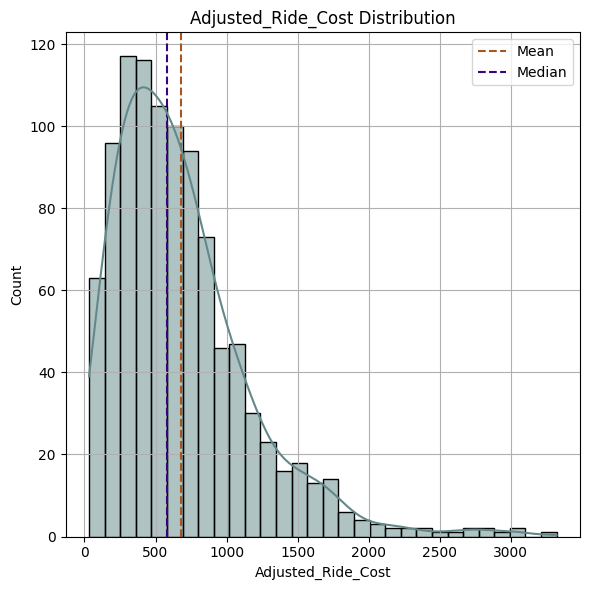

In [20]:
# To visualize the skewness we can plot a graph:
# Create a figure
plt.figure(figsize = (6,6))

# Calculate mean and median of the feature "Adjusted_Ride_Cost"
mean_values_arc = df["Adjusted_Ride_Cost"].mean()
median_arc = df["Adjusted_Ride_Cost"].median()

# Add lines to implement mean and median in the plot
plt.axvline(mean_values_arc, linestyle = "--", label = "Mean", color = "#A9561E")
plt.axvline(median_arc, linestyle = "--", label = "Median", color = "#380282")

# Create histogram 
sns.histplot(df["Adjusted_Ride_Cost"] , kde = True, color = "#638889")

plt.title("Adjusted_Ride_Cost Distribution")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

As we can see in the plot, we have to logarithmically transform the feature to make the skewed data "more normal", as it improves the linearity between the dependent and the independendent variables. To do so, the natural logarithm is used.

In [21]:
df["Adjusted_Ride_Cost_Log"] = np.log(df["Adjusted_Ride_Cost"])

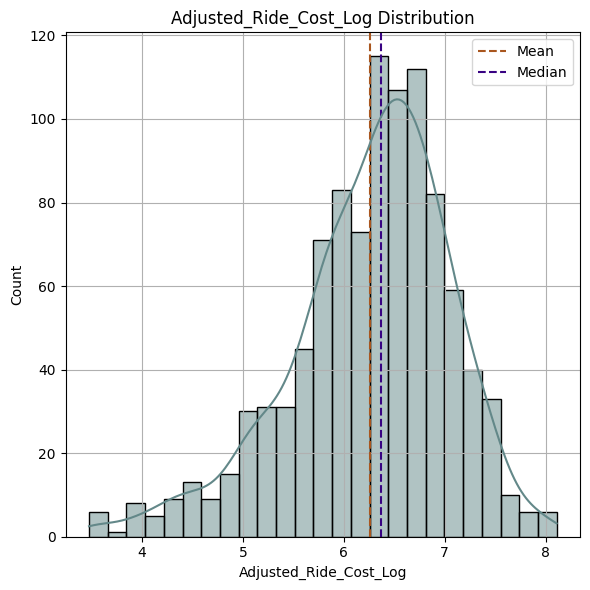

In [22]:
# Now let's visualize the logarithmized feature df["Adjusted_Ride_Cost_Log"]
# Create a figure
plt.figure(figsize = (6,6))
# Calculate mean and median of the feature "Adjusted_Ride_Cost_Log"
mean_values_log = df["Adjusted_Ride_Cost_Log"].mean()
median_log = df["Adjusted_Ride_Cost_Log"].median()

# Add lines to implement mean and median in the plot
plt.axvline(mean_values_log, linestyle = "--", label = "Mean", color = "#A9561E")
plt.axvline(median_log, linestyle = "--", label = "Median", color = "#380282")

# Create histogram 
sns.histplot(df["Adjusted_Ride_Cost_Log"] , kde = True, color = "#638889")

plt.title("Adjusted_Ride_Cost_Log Distribution")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
print("Skewness of Adjusted_Ride_Cost: ", round(df["Adjusted_Ride_Cost_Log"].skew(), 3))

Skewness of Adjusted_Ride_Cost:  -0.734


Now the graph already looks more normally distributed since the skewness only is half the size of what it was before.  

As the next step, we have to check the skewness for the other features, which in this project are the ```Number_of_Riders```, ```Expected_Ride_Duration``` and ```Number_of_Drivers```. As we can see below, only the feature of ```Number_of_Drivers``` has to be normalized. This can either be realized by logarithmic transformation or by Box-Cox-Transformation. The BCT tries to find the smallest standard deviation for the data, which usually has a high probability of also being closer to the normal distribution.

In [24]:
print("Skewness of Number_of_Riders: ", round(df["Number_of_Riders"].skew(), 3))
print("Skewness of Expected_Ride_Duration: ", round(df["Expected_Ride_Duration"].skew(), 3))
print("Skewness of Number_of_Drivers: ", round(df["Number_of_Drivers"].skew(), 3))

Skewness of Number_of_Riders:  0.002
Skewness of Expected_Ride_Duration:  -0.14
Skewness of Number_of_Drivers:  0.963


In [25]:
# Compute optimal Box-Cox transform parameter for input data
lmbda = boxcox_normmax(df["Number_of_Drivers"])

# Return a dataset transformed by a Box-Cox power transformation
df["Number_of_Drivers_BC"] = stats.boxcox(df["Number_of_Drivers"], lmbda = lmbda)

# Look at the skewness value
print("Skewness of Number_of_Drivers_BC: ", round(df["Number_of_Drivers_BC"].skew(), 3))

Skewness of Number_of_Drivers_BC:  0.018


Now we do have a very solid value of 0.018 the skewness of the feature ```Number_of_Drivers_BC``` which we can use for further calculations.  
To visualize how much the dynamically adjusted price affects the revenue, a graph is plotted in the next step which shows a large growth of the revenue.

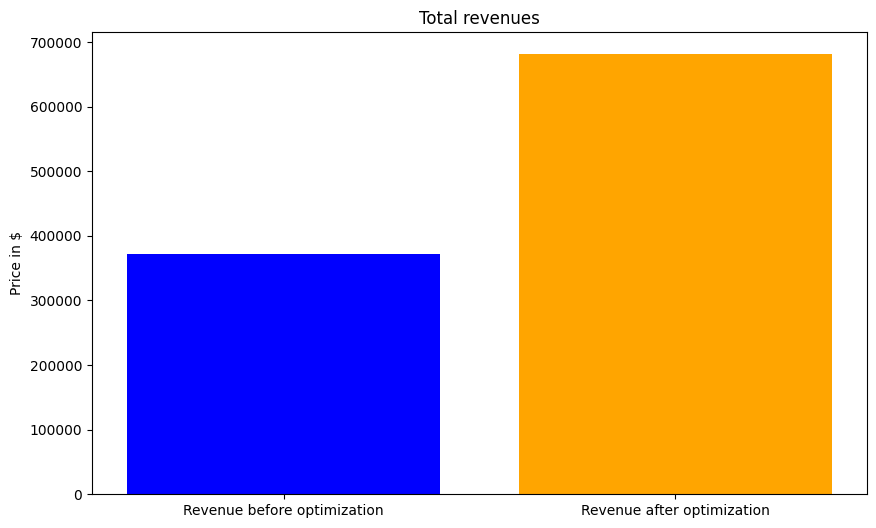

In [26]:
# Declaring variables with the sum of each column
adjusted_ride_cost_sum = df["Adjusted_Ride_Cost"].sum()
historical_cost_of_ride_sum = df["Historical_Cost_of_Ride"].sum()

# Creating dictionary with labels of the bars and the summed up columns
sums = {
    "Revenue before optimization": historical_cost_of_ride_sum,
    "Revenue after optimization": adjusted_ride_cost_sum
}

# Creating bar chart
plt.figure(figsize=(10, 6))
plt.bar(sums.keys(), sums.values(), color=["blue", "orange"])
plt.ylabel("Price in $")
plt.title("Total revenues")
plt.show()

Before we can start to train our machine learning model, the categorical features have to be encoded, since only numeric values are able to be considered in the models. The relevant data for our prediction of a future adjusted pricing model consist of the following features:  
```Number_of_Riders```, ```Number_of_Drivers```, ```Expected_Ride_Duration``` and ```Vehicle_Type```.  
The other columns, ```Number_of_Past_Rides```, ```Average_Ratings```, ```Location_Category```, ```Customer_Loyalty_Status``` and ```Time_of_Booking``` can be ignored.  
Therefore, the encoding only applies to the ```Vehicle_Type```, where all premium vehicles are represented as 1 and all economy vehicles are represented as 0.

In [27]:
# Encoding of Vehicle_Type
df["Vehicle_Type_enc"] = [1 if type == "Premium" else 0 for type in df["Vehicle_Type"]]
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Color,Demand_Multiplier,Supply_Multiplier,Adjusted_Ride_Cost,Profit_Percentage,Adjusted_Ride_Cost_Log,Number_of_Drivers_BC,Vehicle_Type_enc
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,blue,1.111111,0.844444,266.710528,-6.172840,5.586164,4.841747,1
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,orange,1.450000,0.974359,245.653817,41.282051,5.503923,4.616307,0
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,blue,1.050000,1.225806,424.478684,28.709677,6.050862,4.262738,1
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,blue,1.098765,1.357143,701.155452,49.118166,6.552730,4.109115,1
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,orange,1.950000,1.727273,1952.472427,236.818182,7.576852,3.752627,0


In the next step we can futher scale and standardize our features required in different machine learning models. By standardizing the data, each value gets rescaled so that they have mean of 0 and variance of 1. This is necessary to bring down the values to a common scale without distorting the differences in the range of values.

In [28]:
# Define target variable y
y = df["Adjusted_Ride_Cost"]
# Define feature matrix X
X = df[["Number_of_Riders", "Number_of_Drivers_BC", "Expected_Ride_Duration", "Vehicle_Type_enc"]]

# Instance of the StandardScaler
scaler = StandardScaler()

# Scale the feature matrix X 
X_scaled = scaler.fit_transform(X)

# Split the data into a training and a testing set with a testsize of 20% and random_state = 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

# 5. Model Implementation

At the beginning we want to create two dictionaries: one for all machine learning models we want to train with our data and one for the parameters required for the models.

In [29]:
# Define all regression models we want to train as machine learning models in this project
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(objective="reg:squarederror"),
    "CatBoostRegressor": CatBoostRegressor(verbose=0)
}

# Settings for each model's hyperparameter
params = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0]},
    "Lasso": {"model__alpha": [0.001, 0.01, 0.1]},
    "ElasticNet": {"model__alpha": [0.001, 0.01, 0.1], "model__l1_ratio": [0.25, 0.5, 0.75]},
    "SVR": {"model__C": [0.1, 1, 10], "model__epsilon": [0.01, 0.1, 1.0], "model__kernel": ["linear", "rbf"]},
    "RandomForestRegressor": {"model__n_estimators": [10, 50, 100]},
    "XGBRegressor": {"model__learning_rate": [0.1, 0.5], "model__max_depth": [3, 5, 7]},
    "CatBoostRegressor": {"model__learning_rate": [0.01, 0.1, 0.5], "model__depth": [4, 6, 8]}
}


In the next step a function is defined which allows to calculate the root mean squared error, which measures the average magnitude of the errors between predicted and observed values.  
It simply takes the square root of the MSE, which looks like this: $L(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^{n} \left(y_i - \hat{y}_i\right)^2$.  
A lower RMSE usually indicates a better fit of the model.

In [30]:
# RMSE function
def rmse(y_actual, y_pred):
    return math.sqrt(mean_squared_error(y_actual, y_pred))

# Scorer which indicates that lower values are better than higher values
rmse_scorer = make_scorer(rmse, greater_is_better = False)

Now we can start to build a loop which iterates over all machine learning models previously defined in ```models```.  
Simultaneously the models are being evaluated by the R²-score and the RMSE.

In [31]:
# Empty list to store the values
results = []

# Variables to track best model and its R²-score
best_model = None
best_r2 = float("-inf")

# Iterate over each model in the models-dictionary with the pipeline method to make iteration easier and more readible
for name, model in models.items():
    # Create a pipeline with the model
    pipeline = Pipeline([
        ("model", model)
    ])

    # Check if hyperparameters are defined in theh dictionary
    if name in params:
        # If hyperparameters are defined, gridsearch with crossvalidation = 5 is being performed
        grid_search = GridSearchCV(pipeline, params[name], cv = 5, scoring = rmse_scorer)
    else:
        # If hyperparameters are not defined, gridsearch with default parameters is being perform
        grid_search = GridSearchCV(pipeline, {}, cv = 5, scoring = rmse_scorer)

    # Fit the training set on each model
    grid_search.fit(X_train, y_train)

    # Define the predicted value y_pred
    y_pred = grid_search.predict(X_test)

    # Calculate R²-score and RMSE-value
    r2 = r2_score(y_test, y_pred)
    rmse_val = rmse(y_test, y_pred)

    # After comparing the r² values, always store the higher r² as the best_r2
    if r2 > best_r2:
        best_r2 = r2
        best_model = grid_search

    # Append all necessary information to the results list
    results.append({
        "Model": name,
        "R-Squared_Score": r2,
        "RMSE_Score": rmse_val,
        "Best_Parameters": grid_search.best_params_    
    })

# Create a DataFrame from the results list
df_results = pd.DataFrame(results)

In [32]:
# Show the results, rounded off by 5 digits
pd.set_option("display.float_format", "{:.4f}".format)
df_results

,Model,R-Squared_Score,RMSE_Score,Best_Parameters
0,Ridge,0.5573,318.4346,{'model__alpha': 10.0}
1,Lasso,0.5579,318.2414,{'model__alpha': 0.1}
2,ElasticNet,0.5576,318.3427,"{'model__alpha': 0.01, 'model__l1_ratio': 0.25}"
3,SVR,0.5106,334.8292,"{'model__C': 10, 'model__epsilon': 0.01, 'mode..."
4,RandomForestRegressor,0.8666,174.7997,{'model__n_estimators': 100}
5,XGBRegressor,0.8761,168.4906,"{'model__learning_rate': 0.1, 'model__max_dept..."
6,CatBoostRegressor,0.8945,155.4311,"{'model__depth': 6, 'model__learning_rate': 0.01}"


In [33]:
# Predictions on X_test
y_pred = best_model.predict(X_test)

# Compute R² 
r2 = r2_score(y_test, y_pred)

print(f"R² = {r2}")

R² = 0.8945376843150377


As we can see, ```CatBoostRegressor``` does have the highest R²-score (= 0.8945) and the lowest RMSE_Score (= 155.4311) which makes it the best machine learning model for us to predict the target variable ```Adjusted_Ride_Cost```.  
Now we can use that model to make predictions on the test set.

Analyzing this pie chart is simple, since there exist 3 major features, which have a big influence on the Adjusted_Ride_Cost.  
The Vehicle_Type_enc doesn't even have that much of an influece, which is why we could ignore it for further models.  
Furthermore, we could improve the model's performance by hyperparameter tuning, where you can edit every single parameter to improve the performance.  
The code below showcases an example of what the anticipated price is going to be with specified parameters which are given to the model.

In [34]:
# Defining a variable model with CatBoostRegressor and adjusted hyperparameter tuning

model = CatBoostRegressor(verbose = 0, subsample = 0.9, learning_rate = 0.05, l2_leaf_reg= 1.4, iterations = 750, depth = 4)

# Fit the model to the training data
model.fit(X_train, y_train)

# Extract feature importances from the trained model
feature_coefficients = pd.DataFrame(model.feature_importances_, index = X.columns, columns=["Importance"]).sort_values(by = "Importance", ascending = False)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(y_test, y_pred)

# Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.898699597552978


To visualize what features are the most important and which ones do have the most influence on the outcome ```y```,  the following plot is being used.

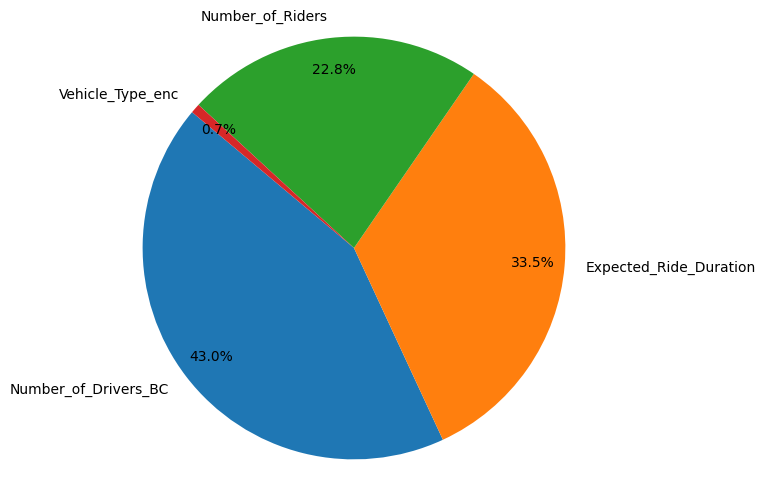

In [41]:
plt.figure(figsize=(6, 6))

# Create a pie chart
plt.pie(feature_coefficients["Importance"].values, labels=feature_coefficients.index, autopct="%1.1f%%", startangle=140, labeldistance = 1.1, pctdistance = 0.85, normalize=True)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis("equal")

plt.show()

In [36]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric
  
# Price prediction based on the values of the user input
def price_prediction(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Undefined Vehicle type")

    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

# Example

user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
Expected_Ride_Duration = 30

anticipated_price = price_prediction(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print(f"The anticipated price with the current values is: {anticipated_price}")

The anticipated price with the current values is: [405.80206558]


To finish this project we can plot a regression which plots the actual values against the predicted values and draws a line where the ideal price would be.  
As we can see, the line is not perfecty aligned with each value, which indicates that our model is not overfitted, yet it has a low variance so it is good enough to be a prediction model.

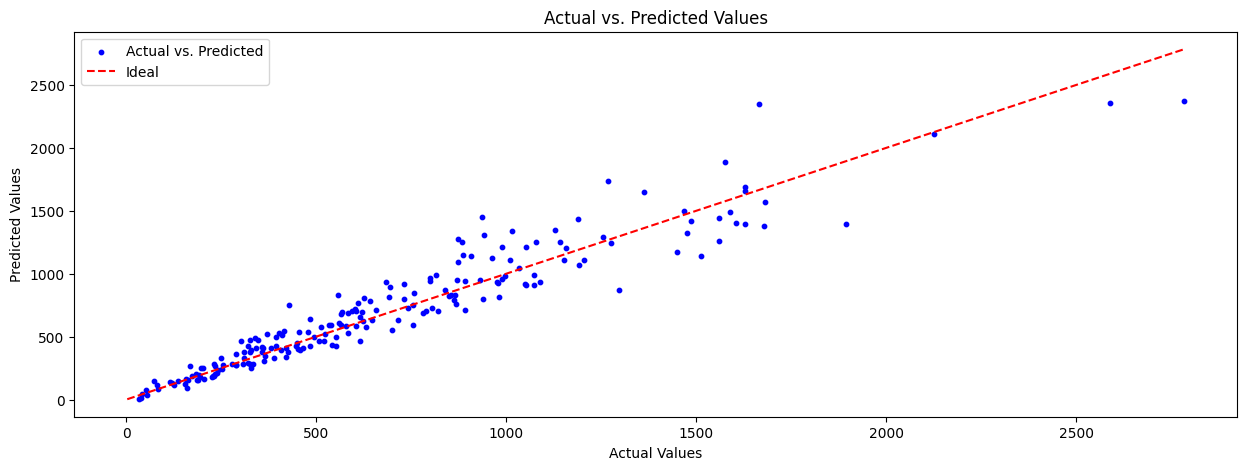

In [37]:
# To show a comparison between the actual values and the predicted values, we can scatter a plot

# Prediction of the test set
y_pred = model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.scatter(y_test, y_pred, label = "Actual vs. Predicted", color="blue", s = 10)

# Adding the min/max lines for the plot
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color = "red", linestyle = "--", label = "Ideal")

# Naming the title and the axes
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

In [38]:
# Save new file if not yet existing

filename_new = "dynamic_pricing_adjusted.csv"

if not os.path.exists(filename_new):
    df.to_csv(filename_new, index = False)
    print(f"File {filename_new} was saved.")
else:
    print(f"File {filename_new} already exists.")

File dynamic_pricing_adjusted.csv already exists.


In [54]:
directory = r"C:\Users\Felix\Desktop\Excel Sheets"
filename_new = os.path.join(directory, "dynamic_pricing_adjusted.xlsx")
filename_neww = "dynamic_pricing_adjusted.xlsx"

if not os.path.exists(filename_new):
    df.to_excel(filename_new, index=False)
    print(f"File {filename_neww} was saved.")
else:
    print(f"File {filename_neww} already exists.")

File dynamic_pricing_adjusted.xlsx already exists.


In [46]:
# Check Python Version
!python --version

Python 3.11.7
